In [1]:
from models.mnist_classifier.lenet import LeNet5, LeNet1
import torch
import torchvision
from torchvision.datasets.mnist import MNIST
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAMpp, GradCAM
import torchvision.models as models
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import os
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# lenet1的输入是28*28，lenet5的输入是32*32
net = torchvision.models.resnet18(pretrained=False)
# net = LeNet1()
# net_dir = 'save_model/Lenet1/lenet_epoch=12_test_acc=0.985.pth'
net_dir = 'autodl-tmp/save_model/fashion/resnet18/resnet_epoch=2_test_acc=0.853.pth'
net.load_state_dict(torch.load(net_dir))
net.eval()
net = net.to(device)

In [3]:
# 将数据集转换为PyTorch张量，并将像素值标准化为范围在0到1之间
mean = [0.5]
std = [0.5]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
data_root = './autodl-tmp/fashion-mnist'
trainset = FashionMNIST(root=data_root, train=True,
                                        download=False,transform=transform)
testset = FashionMNIST(root=data_root, train=False,
                                       download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=False, num_workers=8)

In [4]:
(ims, labs) = next(iter(testloader))	# images：Tensor(64,1,28,28)、labels：Tensor(64,)
ims = ims.to(device)
labs = labs.to(device)


In [5]:
labs = labs.cpu().numpy()

In [6]:
# 计算预训练模型acc
preds = net(ims).cpu().detach().numpy()
class_preds = np.argmax(preds, axis=1)
print(class_preds)
print('test acc', np.sum(class_preds == labs) / len(testset))

RuntimeError: CUDA out of memory. Tried to allocate 29.91 GiB (GPU 0; 23.69 GiB total capacity; 5.65 GiB already allocated; 15.94 GiB free; 5.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
# 预测单张图
def pred_one_pic(im):
    img_tensor = Variable(torch.unsqueeze(im, dim=0).float(), requires_grad=False)
    output = torch.softmax(net(img_tensor),dim=1)
    pred_val, pred_idx = torch.max(output, 1)
    return float(pred_val[0]), int(pred_idx[0])  # 概率，标签
x_pred_prob = float(pred_one_pic(ims[1])[0] * 100)
print(x_pred_prob)

90.00734686851501


In [8]:
# 加载示例图像并进行预处理
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize(mean, std)])
image_path = 'testcases/test/1/0.png'
image = Image.open(image_path)
input_image = preprocess(image)
input_image = input_image.unsqueeze(0)  # 添加批次维度

FileNotFoundError: [Errno 2] No such file or directory: 'testcases/test/1/0.png'

In [8]:
ims[1].shape

torch.Size([1, 32, 32])

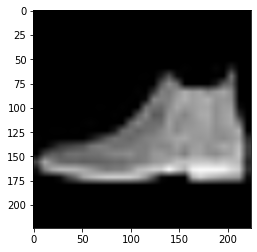

In [9]:
for im in ims:
    # pytorch网络输入图像的格式为（C, H, W)，而numpy中的图像的shape为（H,W,C）。故需要变换通道才能有效输出
    im = im.cpu().numpy().transpose(1, 2, 0) 
    std = [0.5, 0.5, 0.5]
    mean = [0.5, 0.5, 0.5]
    im = im * std + mean
    plt.imshow(im)
    plt.show()
    break

In [10]:
# gradcam
layers = list(net.modules())

In [11]:
len(layers)

68

In [12]:
layers[64]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [14]:
layers

[ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [13]:
cam = LayerGradCam(net, layer=layers[64])  # relu_attributions=True？

In [14]:
loaders_scratch = {'train': trainloader, 'test': testloader}
X, Y = iter(loaders_scratch['test']).next()
X, Y = X.to(device), Y.to(device)
Y_logits = net(X)
Y_probs = F.softmax(Y_logits, dim=-1)
Y_preds = Y_probs.argmax(axis=-1)

RuntimeError: CUDA out of memory. Tried to allocate 29.91 GiB (GPU 0; 23.69 GiB total capacity; 11.26 GiB already allocated; 10.31 GiB free; 11.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

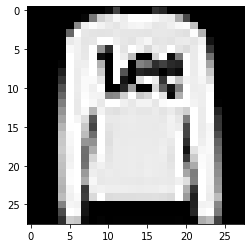

In [15]:
# 你下次打开肯定忘了：这里X是图像，Y是对应的标签，一共10000张。X[1:2][0]是(1,32,32)的一张图
orig_image = X[1:2][0].numpy().transpose(1, 2, 0)  # 交换通道
std = [0.5, 0.5, 0.5]
mean = [0.5, 0.5, 0.5]
orig_image = orig_image * std + mean
plt.imshow(orig_image)
plt.show()

In [15]:
feature_imp_img = cam.attribute(X[1:2], target=Y[1:2])
upsampled_attr = LayerAttribution.interpolate(feature_imp_img, (32, 32))  # 把本来8*8的热力图映射成原图28*28大小
print(feature_imp_img.shape)
print(upsampled_attr.shape)

torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 32, 32])


In [ ]:
upsampled_attr  # 这是28*28的热力图值，后续找最大的，构成循环

In [18]:
heatmap_preview = upsampled_attr[0][0].detach().cpu().numpy()

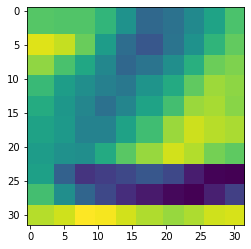

In [19]:
np.argmax(heatmap_preview)
plt.imshow(heatmap_preview)
plt.show()

In [20]:
k = 32*32
heat_topk = torch.topk(torch.abs(upsampled_attr)[0][0].flatten(), k).indices  # topk热力值的索引位置（将整个32x32拉通了）
heat_topk = heat_topk.tolist()

In [21]:
print(heat_topk[:20])

[855, 887, 856, 889, 888, 857, 921, 920, 919, 797, 798, 767, 799, 766, 765, 831, 830, 829, 764, 763]


In [22]:
import math

# 计算热力图标准差
def StandardDeviation(map):  # map为热力图
    n = len(map) ** 2
    h_average = sum(sum(map)) / n
    total = 0
    for hi in map:
        for hj in hi:
            total += (hj - h_average) ** 2  
    total /= n
    return math.sqrt(total)
StandardDeviation(heatmap_preview)

5.5735986170556825e-11

In [23]:
img_tensor = torch.unsqueeze(ims[1], dim=0).float()
img_variable = Variable(img_tensor, requires_grad=True)
output = net.forward(img_variable)
label_idx = int(torch.max(output.data, 1)[1][0])   #get an index(class number) of a largest element
print(label_idx)

2


In [24]:
ims[1].shape

torch.Size([1, 32, 32])

In [25]:
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
x_pred = labels[label_idx]
print(x_pred)

2


In [26]:
# FGSM
y_true = 2   #tiger cat  ##change this if you change input image
target = Variable(torch.LongTensor([y_true]), requires_grad=False)
print(target)

tensor([2])


In [27]:
#perform a backward pass in order to get gradients
loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(output, target)
loss_cal.backward(retain_graph=True)    #this will calculate gradient of each variable (with requires_grad=True) and can be accessed by "var.grad.data"

In [28]:
def add_advblock(x_tmp, x_grad, heat_topk, k, width):
    i = heat_topk[k] // width
    j = heat_topk[k] % width
    x_tmp[0][0][i][j] = x_grad[0][0][i][j]
    return x_tmp

In [61]:
eps = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
x_grad = torch.sign(img_variable.grad.data)                #calculate the sign of gradient of the loss func (with respect to input X) (adv)
x_tmp = torch.zeros(1, 1, 32, 32)

In [62]:
# 处理，只保留选中方框内的梯度值
for i in range(len(heat_topk)):
    x_tmp = add_advblock(x_tmp, x_grad, heat_topk, i, 32)
    x_adversarial = img_variable.data + eps[8] * x_tmp
    output_adv = net.forward(Variable(x_adversarial))
    x_adv_pred = labels[int(torch.max(output_adv.data, 1)[1][0])]
    if x_adv_pred != x_pred:
        break
print(i)

336


In [63]:
x_adv_pred = labels[int(torch.max(output_adv.data, 1)[1][0])]
print(x_adv_pred)

1


In [64]:
op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
adv_pred_prob = float((torch.max(op_adv_probs.data, 1)[0][0]) * 100)      #find probability (confidence) of a predicted class
print(adv_pred_prob)

41.33356475830078


In [65]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    std = [0.5, 0.5, 0.5]
    mean = [0.5, 0.5, 0.5]
    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose(x, (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose(x_adv, (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

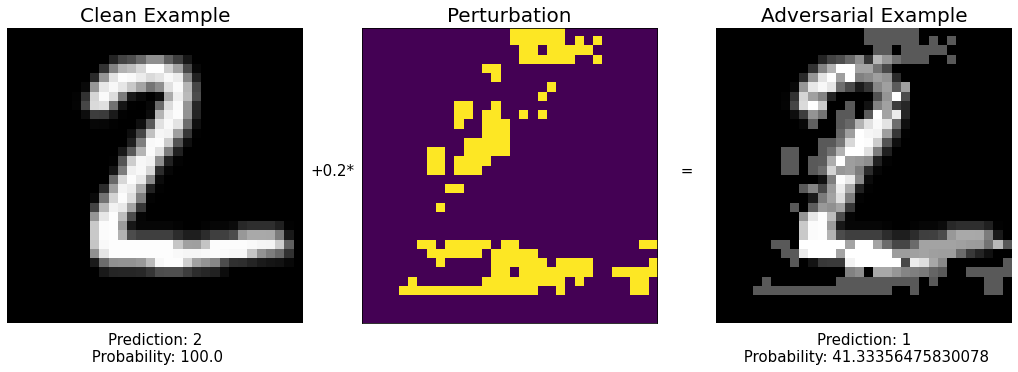

In [66]:
visualize(img_tensor, x_adversarial, x_tmp, eps[3], x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)